In [2]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 f

# The EFRQI Model


In The EFRQI color represenation model for $2^n × 2^n$ image, $2n + 1$ qubits to store gray images, where $2n$ qubits are used to store position and 1 qubit to store the colour information entangled with qubit sequence.

The quantum state of the image can be represted as
$$
|I> = 1/2^n \sum_{i=0}^{2^{2^n -1}}  (a_i |0>+ b_i |1>)|i>
$$

where a and b are the amplitudes of the state storing colour information



A simple example for a 
2 × 2   image is given below, with corresponding color encoding and associated kets (position encoding) :

<table>
<tr>
<td> 0   |00>  </td>
<td> 70  |01></td>
</tr>
<tr>
<td> 120 |10> </td>
<td> 255 |11></td>
</tr>    
</table>


And the equivalent quantum state is
$$
|I> = 1/2 (|0>|00> + (a_{01}|0>+b_{01}|1>)|01> + (a_{10}|0>+b_{10}|1>)|10> + (a_{11}|0>+b_{11}|1>)|11> )
$$



## Building the EFRQI State: A Two Step Process 
1- Start with initial state $$|\psi>= |0> ^{ \otimes 2n+1}$$
2- Storing the position of the pixels of a black image by transforming the initial
state $|0⟩$ into the intermediate state $|1⟩$ using the single qubit gates I and H, with a quantum operation 
$$ 
|\psi>= (H|0>{ \otimes 2n}) \otimes (I|0>)
$$
$$
= 1/2^n \sum_{X=0}^{2^{2^n -1}} \sum_{Y=0}^{2^{2^n -1}} |0>|YX>
$$
3- To complete the image preparation, a quantum sub operation $V_{YX}$ which consists
of $2^{2n}$ sub operations to set the gray value for every pixel in the image.
You can view $V_{YX}$ as controlled partial negation operator RX defined by: 
$$
V_{YX} = (I \otimes \sum_{X=0}^{2^{2^n -1}} \sum_{Y=0}^{2^{2^n -1, ji\neq YX}} |ji><ji| ) + \Gamma_{YX} \otimes |YX><YX|
$$
Where $\Gamma_{YX}$ is partial negation operator RX defined applied $d$ times. The partial negation operator RX is the kth root of the X gate and can be calculated using the following matrix
$$
RX= \sqrt[K]{X} = 1/2 \begin{bmatrix}
1+t & 1-t \\
1-t & 1+t 
\end{bmatrix}
$$
where $t$ is $ \sqrt[K]{-1}$.

Applying the RX gate for d times on a qubit can be calculated as follows
$$
RX^d= 1/2 \begin{bmatrix}
1+t^d & 1-t^d \\
1-t^d & 1+t^d 
\end{bmatrix}
$$
In Our context $K$ is 255 and $d$ is the pixel value.
So the operation of setting the gray value for the pixel at position (Y, X) is,
$$
    \Gamma_{YX} |0>|YX> = \prod_{i=1}^{d} {RX_{YX}}^i(|YX>|0>)= X^{d/255} |YX>|0> =  (a_{YX} |0>+ b_{YX} |1>)|YX>
$$

Note that we still need to take care of the increment in the pixel location, this is done via the  X   gates.



## Implementation and Measurement : 2^n×2^n Image with Grayscale Values

In [3]:
# Importing standard Qiskit libraries and configuring account
import qiskit as qk
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_histogram
from math import pi
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import *


### The partial negation operator RX

In [4]:
def RX_Partial_negation(K,D):
    t_k_d= (-1)**(D/K)
    matrix_RX_d= 1/2* np.array([[1+ t_k_d , 1- t_k_d], [1 - t_k_d, 1 + t_k_d]])
    RX_d = Operator(matrix_RX_d) 
    return UnitaryGate(RX_d,label='Partial RX')

### Define circuit

Function takes number number of qubits n and array of Pixel values which should range from [0,255]

In [5]:
def apply_controlled_rotation(circuit,n,pixel_values):
    position_containing_x_gate=[]
    number_possible_combination=2^n
    previos_index_x_gate=[]
    circuit.barrier()
    for val in range(number_possible_combination+1):
        circuit.barrier()
        current_position_x_gate= [i for i in range(val.bit_length()) if val & (1<<i)]
        ### Remove x_gate if not used in currect bit-string
        if len(previos_index_x_gate)!=0:
            for index in previos_index_x_gate:
                if not (index in current_position_x_gate):
                    circuit.x(index)
        ### Apply x-gate to indecies for current bit-string
        for index in current_position_x_gate:
            if not (index  in previos_index_x_gate):
                circuit.x(index)
        previos_index_x_gate=current_position_x_gate
        
        ## Get operator rotation
        RX_partial_gate=RX_Partial_negation(255,pixel_values[val])
        ### Apply controlled operation
        
        RX_partial_gate_control_gate=RX_partial_gate.control(2*n)
        
        circuit.append(RX_partial_gate_control_gate,list(range((2*n) + 1)))
        
        
            
                
        
        
        
        
    

In [6]:
def EFRQI_Circuit(n,pixel_array):
    # First specify number of quibits needed 2n+1, 2n for storing postion information and 1 quibit for storing colour information
    qc = QuantumCircuit((2*n)+1)
    # Apply Hadamard Gate on First 2n qubits
    for i in range(2*n):
        qc.h(i)
        
    
    apply_controlled_rotation(qc,n,pixel_array)

    
    return qc
    
    
    

In [7]:
n=1
pixel_array=[0,70,120,255]
circuit=EFRQI_Circuit(n,pixel_array)

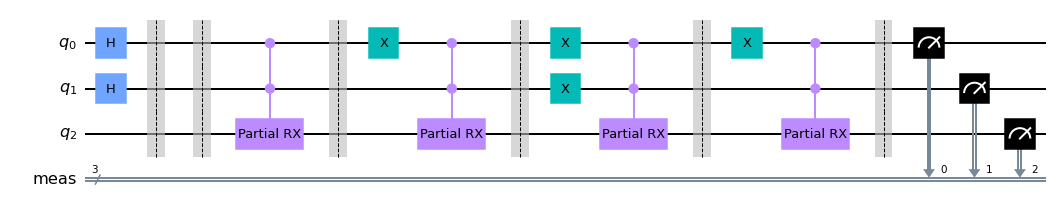

In [8]:
circuit.measure_all()
circuit.draw()

{'111': 1028, '110': 507, '010': 548, '000': 982, '101': 189, '001': 842}


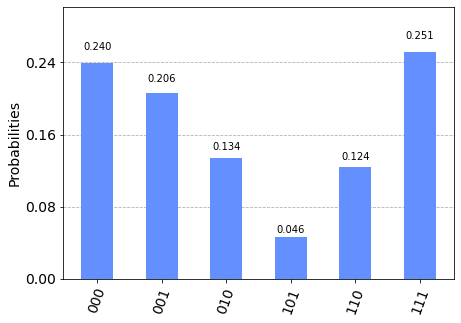

In [9]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(circuit, aer_sim)
qobj = assemble(t_qc, shots=4096)
result = aer_sim.run(qobj).result()
counts = result.get_counts(circuit)
print(counts)
plot_histogram(counts)

# The ENEQR Modle

The ENEQR inspired by NEQR model. For a $2^n x 2^n $ image the ENEQR uses
two entangled qubit sequences to store the gray value of the pixel and its corresponding
position as follows:
    $$
    |I>= 1/2^n \sum_{Y=0}^{2^{n-1}}\sum_{X=0}^{2^{n-1}} |P(Y,X)>|0>|XY>
    $$
where $|P(Y,X)>$ encodes gray value for a pixel at position $(X,Y)$ represented as binary sequence

$ P(Y, X) = C^0_{XY},  C^1_{XY},.... C^i_{XY} \in [0, 1], P(Y, X) \in [0, 2q− 1].$

The representation Uses $2n + q + 1$ qubits to store gray images. This representation
uses an auxiliary qubit to load the position of the pixel to be changed. Instead of
using $q 2n-CNOT$ gates to set the gray value of every pixel, it uses only one $2n-CNOT$ gate
to load the position to the auxiliary qubit and q CNOT gates to set the gray value for the
pixel then resets the auxiliary qubit to be used for the next pixel and so on which improves
the time complexity and the quantum cost of the circuit.

A simple example for a 
2 × 2   image is given below, with corresponding color encoding and associated kets (position encoding) :

<table>
<tr>
<td> 0   |00>  </td>
<td> 70  |01></td>
</tr>
<tr>
<td> 120 |10> </td>
<td> 255 |11></td>
</tr>    
</table>


And the equivalent quantum state is
$$
|I>= 1/2 (|00000000>|0>|00> + |01000110>|0>|01>+ |01111000>|0>|10> + |11111111>|0>|11>)
$$

## Building ENEQR State: : A Two Step Process 

1- Start with initial state $$|\psi>= |0> ^{ \otimes 2n+q+1}$$
2- Apply Hadamrd gate on first $2n$ qubits and Identity gate on next $q+1$ qubits in order to encode position information in the first $2n$ qubits
The new state can be expressed as 
$$
|\psi>= (I|0> ^ {\otimes q+1}) \otimes (H|0>^ {\otimes 2n})
$$
$$
= 1/2^n  \sum_{Y=0}^{2^{n-1}}\sum_{X=0}^{2^{n-1}} |YX>|0>^ {\otimes q+1}
$$
3- To complete the image preparation, it is required to set the gray value for every pixel. This step is divided into $2^{2n}$ sub operations to set the gray value for every pixel. For pixel (Y, X), the quantum sub operation is expressed as $U_{XY}$
$$
U_{XY}=  (I \otimes \sum_{X=0}^{2^{2^n -1}} \sum_{Y=0}^{2^{2^n -1, ji\neq YX}} |ji><ji| ) + \bar{ \omega_{YX}} \otimes |YX><YX|
$$
where $\bar{ \omega_{YX}}$ is the quantum setting operation for pixel (Y, X). The quantum setting operation consists of two parts: $\omega_{YX}$ for loading the pixel position to the auxiliary qubit and resetting the auxiliary qubit and $\otimes_{i=0}^{q-1} \omega_{YX}'$   for setting the gray value.
$$
\bar{ \omega_{YX}} = (\omega_{YX}) (\otimes_{i=0}^{q-1} \omega_{YX}')(\omega_{YX})
$$
$$
\omega_{YX}= |aux>=|0 \otimes YX >
$$
$$
\omega_{YX}'= |0>= |0 \otimes aux>
$$
In summary if pixel values is zero nothing happens, else apply CNOT gate between $2n$ qubits and auxilary qubit, then apply at most q 2CNOT gates between auxilary qubit  and other q qubits to encode pixel value

## Implementation and Measurement : 2^n×2^n Image with Grayscale Values

In [10]:
from qiskit.circuit.library.standard_gates import XGate

In [31]:
def assign_cnot_value_colour(q,n,circuit,pixel_value):
    current_position_one= [i for i in range(pixel_value.bit_length()) if pixel_value & (1<<i)]
    index_auxilary_quibit= 2*n
    for i in range (len(current_position_one)):
            circuit.cx(index_auxilary_quibit,current_position_one[i]+index_auxilary_quibit+1)
            
    
    

In [25]:
def apply_controlled_operation(qc,n,q,pixel_array):
    number_possible_combination=2^n
    previos_index_x_gate=[]
    qc.barrier()
    for val in range(number_possible_combination+1):
        qc.barrier()
        current_position_x_gate= [i for i in range(val.bit_length()) if val & (1<<i)]
        ### Remove x_gate if not used in currect bit-string
        if len(previos_index_x_gate)!=0:
            for index in previos_index_x_gate:
                if not (index in current_position_x_gate):
                    qc.x(index)
        ### Apply x-gate to indecies for current bit-string
        for index in current_position_x_gate:
            if not (index  in previos_index_x_gate):
                qc.x(index)
        previos_index_x_gate=current_position_x_gate
        ## check value of pixel if zero do nothing else apply CNOT operation
        if pixel_array[val]==0:
            continue
        else:
            multi_contol_not_gate= XGate().control(2*n)
            ## Apply CNOt Gate between auxilary and first 2n quibits
            qc.append(multi_contol_not_gate,list(range((2*n) + 1)))
            
            ### Apply Cnot gate between auxilary and other q qbuits
            assign_cnot_value_colour(q,n,qc,pixel_array[val])            
            
            ### Undo CNOt Gate between auxilary and first 2n quibits
            qc.append(multi_contol_not_gate,list(range((2*n) + 1)))
    

In [13]:
def ENEQR_Circuit(n,q,pixel_array):
    # First specify number of quibits needed 2n+q+1, 2n for storing postion information and 1 auxilary quibits and q quibits for storing colour information
    qc = QuantumCircuit((2*n)+1+q)
    # Apply Hadamard Gate on First 2n qubits
    for i in range(2*n):
        qc.h(i)
        
    
    apply_controlled_operation(qc,n,q,pixel_array)

    
    return qc
    
    
    

In [32]:
n=1
q=8
pixel_array=[0,70,120,255]
circuit=ENEQR_Circuit(n,q,pixel_array)

[1, 2, 6]
[3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6, 7]


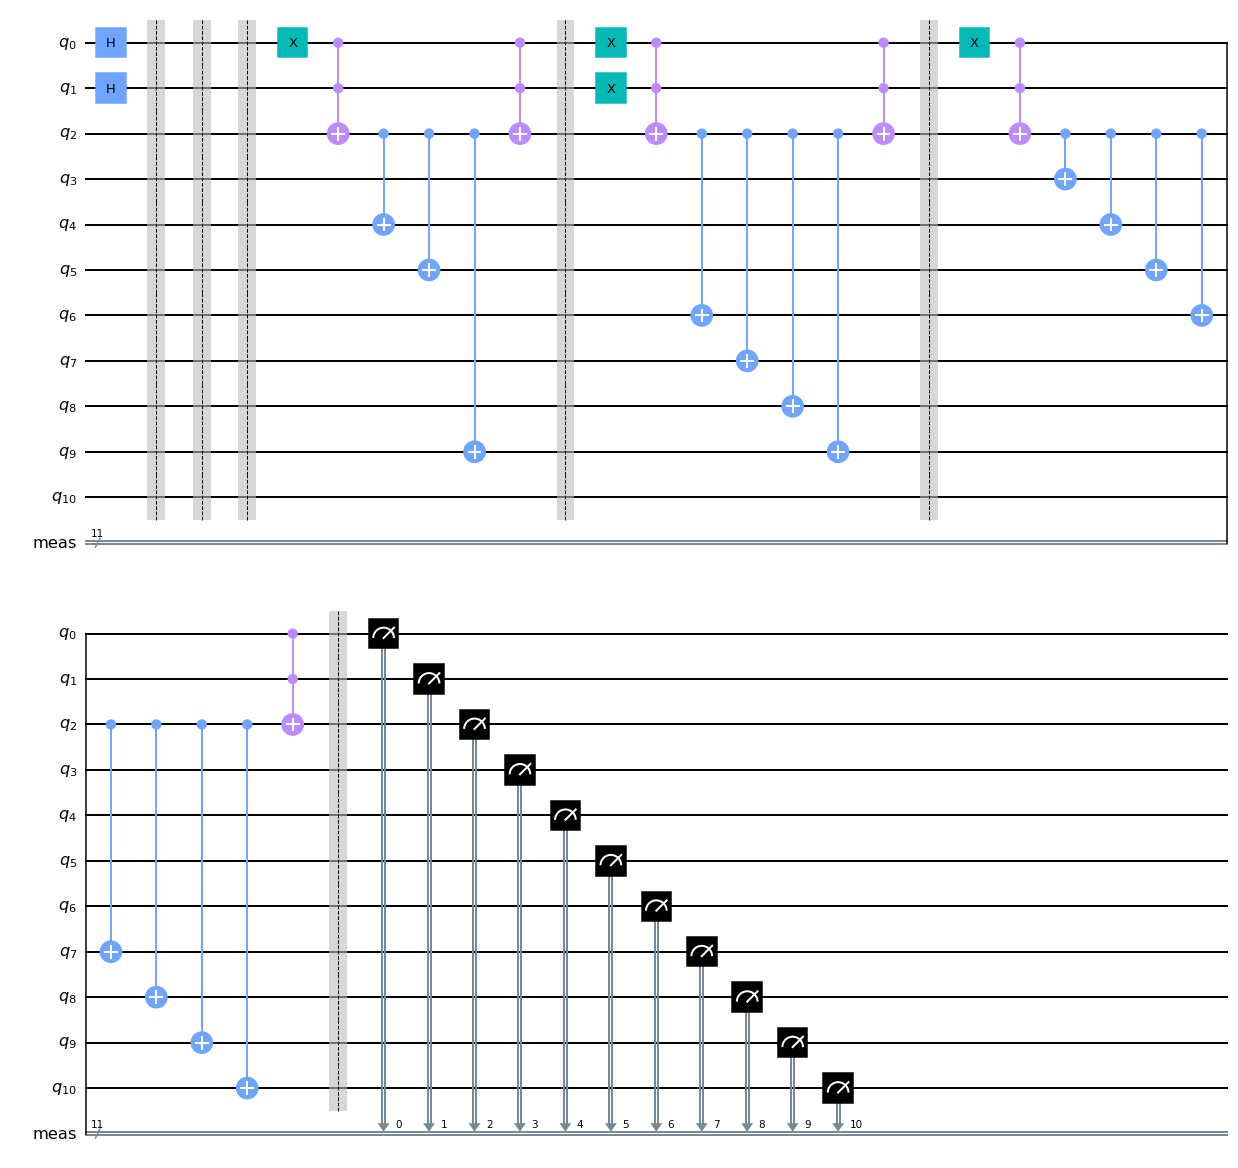

In [33]:
circuit.measure_all()
circuit.draw()

{'00000000000': 1042, '11111111011': 996, '01000110001': 1010, '01111000010': 1048}


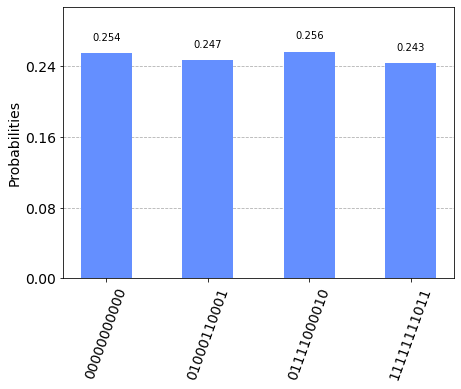

In [34]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(circuit, aer_sim)
qobj = assemble(t_qc, shots=4096)
result = aer_sim.run(qobj).result()
counts = result.get_counts(circuit)
print(counts)
plot_histogram(counts)